In [1]:
import os
import numpy as np
import mindspore as ms
import mindspore.context as context
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV

from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import LossMonitor

context.set_context(mode=context.GRAPH_MODE, device_target='Ascend') # Ascend, CPU, GPU

In [2]:
!wget https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/MNIST.zip
!unzip MNIST.zip

--2021-06-18 07:07:20--  https://professional-construction.obs.cn-north-4.myhuaweicloud.com/deep-learning/MNIST.zip
Resolving proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)... 192.168.0.172
Connecting to proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)|192.168.0.172|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 11684046 (11M) [application/zip]
Saving to: ‘MNIST.zip.1’

MNIST.zip.1         100%[===================>]  11.14M  --.-KB/s    in 0.06s   

2021-06-18 07:07:20 (175 MB/s) - ‘MNIST.zip.1’ saved [11684046/11684046]

Archive:  MNIST.zip
replace MNIST/test/t10k-images-idx3-ubyte? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [5]:
def create_dataset(data_dir, training=True, batch_size=32, resize=(32, 32),
                   rescale=1/(255*0.3081), shift=-0.1307/0.3081, buffer_size=64):
    data_train = os.path.join(data_dir, 'train') # 训练集信息
    data_test = os.path.join(data_dir, 'test') # 测试集信息
    ds = ms.dataset.MnistDataset(data_train if training else data_test)

    ds = ds.map(input_columns=["image"], operations=[CV.Resize(resize), CV.Rescale(rescale, shift), CV.HWC2CHW()])
    ds = ds.map(input_columns=["label"], operations=C.TypeCast(ms.int32))
    # When `dataset_sink_mode=True` on Ascend, append `ds = ds.repeat(num_epochs) to the end
    ds = ds.shuffle(buffer_size=buffer_size).batch(batch_size, drop_remainder=True)

    return ds

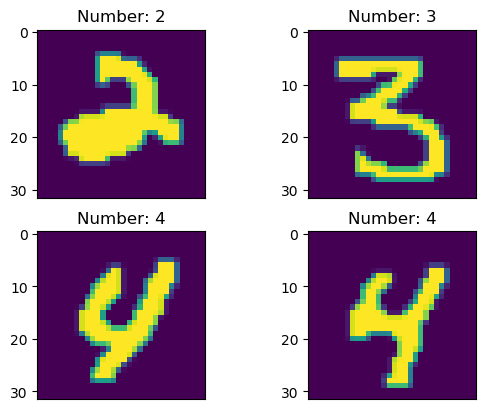

In [6]:
import matplotlib.pyplot as plt
ds = create_dataset('MNIST', training=False)
data = ds.create_dict_iterator().__next__()
images = data['image'].asnumpy()
labels = data['label'].asnumpy()

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.imshow(images[i][0])
    plt.title('Number: %s' % labels[i])
    plt.xticks([])
plt.show()

In [7]:
class LeNet5(nn.Cell):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1, pad_mode='valid')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(400, 120)
        self.fc2 = nn.Dense(120, 84)
        self.fc3 = nn.Dense(84, 10)

    def construct(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

In [8]:
def train(data_dir, lr=0.01, momentum=0.9, num_epochs=3):
    ds_train = create_dataset(data_dir)
    ds_eval = create_dataset(data_dir, training=False)

    net = LeNet5()
    loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    opt = nn.Momentum(net.trainable_params(), lr, momentum)
    loss_cb = LossMonitor(per_print_times=ds_train.get_dataset_size())

    model = Model(net, loss, opt, metrics={'acc', 'loss'})
    # dataset_sink_mode can be True when using Ascend
    model.train(num_epochs, ds_train, callbacks=[loss_cb], dataset_sink_mode=True)
    metrics = model.eval(ds_eval, dataset_sink_mode=True)
    print('Metrics:', metrics)

train('MNIST')

epoch: 1 step: 1875, loss is 2.2896187
epoch: 2 step: 1875, loss is 0.13928533
epoch: 3 step: 1875, loss is 0.11629464
Metrics: {'loss': 0.06563749083010734, 'acc': 0.9790665064102564}
